# How to achieve a local sensitivity analysis with BrigthWay2

First, preparing the environment

In [29]:
from brightway2 import *
from __future__ import unicode_literals, print_function
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)

In [2]:
projects.set_current("Local Sensitivity Analysis demo")

## Init the databases

In [3]:
bw2setup()

Creating default biosphere



Writing activities to SQLite3 database:
0%                          100%
[##########                    ] | ETA: 00:00:00

Applying strategy: normalize_units
Applying strategy: drop_unspecified_subcategories
Applied 2 strategies in 0.01 seconds


[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/17/2017 12:51:38
  Finished: 02/17/2017 12:51:39
  Total time elapsed: 00:00:00
  CPU %: 73.80
  Memory %: 1.02
Created database: biosphere3
Creating default LCIA methods

Applying strategy: normalize_units
Applying strategy: set_biosphere_type
Applying strategy: drop_unspecified_subcategories
Applying strategy: link_iterable_by_fields
Applied 4 strategies in 1.27 seconds
Wrote 665 LCIA methods with 169551 characterization factors
Creating core data migrations



Exemple of how to select a activity in the biosphere data:

In [4]:
Database("biosphere3").search('*wood*')

['Wood, primary forest, standing' (cubic meter, None, ('natural resource', 'biotic')),
 'residual wood, dry' (cubic meter, None, ('social',)),
 'residual hardwood, wet' (cubic meter, None, ('social',)),
 'Wood, soft, standing' (cubic meter, None, ('natural resource', 'biotic')),
 'residual softwood, wet' (cubic meter, None, ('social',)),
 'Wood, hard, standing' (cubic meter, None, ('natural resource', 'biotic')),
 'Wood, unspecified, standing' (cubic meter, None, ('natural resource', 'biotic'))]

How to pick up a LCA method

In [5]:
method_key = methods.random()
method_key

('ReCiPe Midpoint (E) w/o LT', 'fossil depletion w/o LT', 'FDP w/o LT')

Now, importing the Forwast database:

In [6]:
import zipfile
import os
from bw2data.utils import download_file

filepath = download_file("forwast.bw2package.zip", url="http://lca-net.com/wp-content/uploads/")
dirpath = os.path.dirname(filepath)
zipfile.ZipFile(filepath).extractall(dirpath)
BW2Package.import_file(os.path.join(dirpath, "forwast.bw2package"))

Writing activities to SQLite3 database:
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:04


Title: Writing activities to SQLite3 database:
  Started: 02/17/2017 12:52:31
  Finished: 02/17/2017 12:52:36
  Total time elapsed: 00:00:04
  CPU %: 65.50
  Memory %: 1.97


[Brightway2 SQLiteBackend: forwast]

How to search in the database

In [7]:
Database("forwast").search('*wood*')

['__8 Recycling of waste wood, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003']),
 '_32 Wood products, except furniture, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003']),
 '_32 Wood products, except furniture, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003']),
 '107 Waste treatment, Incineration of waste, Wood, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003']),
 '113 Waste treatment, Composting of paper and wood, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003']),
 '117 Waste treatment, Landfill of waste, Wood, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003']),
 '_98 Waste treatment, Incineration of waste, Wood, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003']),
 '104 Waste treatment, Composting of paper and wood, DK' (kilogram, GLO, ['Input Output', 'Denmark 2003']),
 '126 Waste treatment, Landfill of waste, Wood, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003'])]

How to pick up randomly an activity:

In [8]:
activity = Database("forwast").random()
type(activity), activity

(bw2data.backends.peewee.proxies.Activity,
 '_48 Recycling of slags and ashes, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003']))

## Init the LCA

In [9]:
method_key=('ReCiPe Endpoint (I,A)', 'ecosystem quality', 'total')#'IMPACT 2002+ (Endpoint)', 'climate change', 'total')
activity = Database("forwast").search('Wood products EU27')[0]
lca = LCA({activity: 1}, method_key)
#[k for k in methods if any(['total' in e for e in k])]

Here are the correspondances between the BrightWay2 variables names and the matrices in the formula: $h=QBA⁻¹f$
 * A = lca.technosphere_matrix
 * B = lca.biosphere_matrix
 * Q = lca.characterization_matrix
 * f = self.demand_array
 * h = self.characterized_inventory.sum(axis=1)
 * S = self.supply_array
 * g = self.inventory (sure?)

## Compute LCA and fetch matrices

In [10]:
lca.lci()
lca.lcia()
m_a = lca.technosphere_matrix
m_b = lca.biosphere_matrix
m_q = lca.characterization_matrix
h = lca.characterized_inventory.sum(axis=1)
s = lca.supply_array
print('\n'.join(['{} {}\t{}'.format(x, eval(x).shape, type(eval(x))) for x in ['m_a','m_b','m_q','h','s']]))

m_a (277, 277)	<class 'scipy.sparse.csr.csr_matrix'>
m_b (20, 277)	<class 'scipy.sparse.csr.csr_matrix'>
m_q (20, 20)	<class 'scipy.sparse.csr.csr_matrix'>
h (20, 1)	<class 'numpy.matrixlib.defmatrix.matrix'>
s (277,)	<class 'numpy.ndarray'>


A, B and Q are stored as [sparse matrix](https://docs.scipy.org/doc/scipy/reference/sparse.html) with the "Compressed Sparse Row" type, namely [scipy.sparse.csr_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix)

## Computing the Relavite Sensitivity Coefficients
This coefficients are described by [(Wei et al., 2015)](http://pubs.acs.org/doi/abs/10.1021/es502128k)

The formula are:
\begin{align}
\frac{\partial h_k / h_k}{\partial a_{ij} / a_{ij}} & = - \frac{a_{ij}}{h_k} s_j \sum{l}(q_{kl}\lambda_{li}) \\
\frac{\partial h_k / h_k}{\partial b_{ij} / b_{ij}} & = \frac{b_{ij}}{h_k} s_j q_{ki} s_j
\end{align}

It can be rewrited as:
\begin{align}
RSC_k(A)_{ij} = - A_{ij}/h_k * Q.Λ
\end{align}
where $\frac{\partial h_k / h_k}{\partial a_{ij} / a_{ij}}$ (or $RSC_k(A)_{ij}$) is the relative sensitivity coefficient for the technosphere matrix A and the environmental impact $h_k$, and Λ is the intensity matrix defined by $Λ = B.A⁻¹$.

### Intermediary result, computing $Λ$

So for getting $Λ$, we have to solve the system $Λ.A=B$ that is equivalent to $A^T.Λ^T=B^T$ (don't forget to transpose the solve result to get $Λ$).


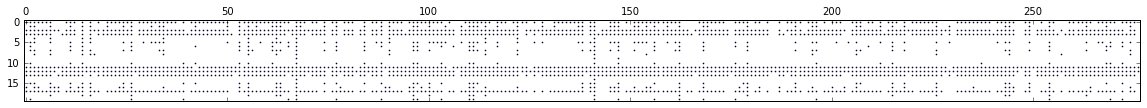

In [31]:
try:
    from pypardiso import factorized, spsolve
except ImportError:
    from scipy.sparse.linalg import factorized, spsolve
m_lambda = spsolve(m_a.transpose(),m_b.transpose()).transpose()
plt.spy(m_lambda,precision=0.01, markersize=1)
plt.show()

Because of the warning about the singularity of A, let's compute the determinant

det(A) = 2.511434778587812e-10


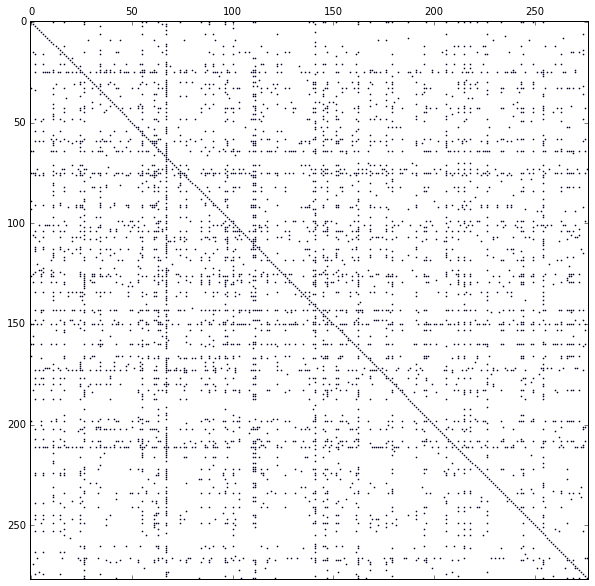

In [32]:
from scipy import linalg
print("det(A) = {}".format(linalg.det(m_a.todense())))
plt.spy(m_a,precision=0.01, markersize=1)
plt.show()

### Effectively computing the RSC

In [13]:
from scipy.sparse import csr_matrix
m_ql = np.dot(m_q, m_lambda)
rsca = [-csr_matrix(s).multiply(m_ql[k,:].transpose().multiply(m_a)).multiply(1/hk) for k,hk in enumerate(h)]

In [14]:
print("Number of non-null elements in rsca: {}".format([sum([len(t) for t in rsca_i.nonzero()]) for rsca_i in rsca]))

Number of non-null elements in rsca: [0, 0, 0, 0, 29466, 0, 0, 29466, 29466, 0, 0, 0, 29466, 0, 0, 29466, 29466, 0, 0, 0]


In [15]:
rscb = [m_q[k,:].transpose().multiply(m_b).multiply(csr_matrix(s)).multiply(1/hk) for k,hk in enumerate(h)]

In [16]:
print("Number of non-null elements in rscb: {}".format([sum([len(t) for t in rscb_i.nonzero()]) for rscb_i in rscb]))

Number of non-null elements in rscb: [0, 0, 0, 0, 248, 0, 0, 244, 204, 0, 0, 0, 242, 0, 0, 244, 252, 0, 0, 0]


### Matrix rows and columns semantics
How to retrieve information about an element of the biosphere and technosphere matrices.

According to the source code of TechnosphereBiosphereMatrixBuilder in brightway2-calc / bw2calc / matrices.py, the rows of the biosphere matrix correspond to the biosphere elements and its columns to the activities, and the rows of the technosphere matrix correspond to the activities and its columns to the products.

In [17]:
activity

'_32 Wood products, except furniture, EU27' (kilogram, GLO, ['Input Output', 'EU27 2003'])

In [18]:
lca.biosphere_dict

{('biosphere3', '0795345f-c7ae-410c-ad25-1845784c75f5'): 16,
 ('biosphere3', '20185046-64bb-4c09-a8e7-e8a9e144ca98'): 4,
 ('biosphere3', '2d9f9c6b-8dca-4641-8ff9-53cb8beabd13'): 14,
 ('biosphere3', '349b29d1-3e58-4c66-98b9-9d1a076efd2e'): 12,
 ('biosphere3', '423ef039-6057-4f63-94bd-e9410d024bd0'): 11,
 ('biosphere3', '7c337428-fb1b-45c7-bbb2-2ee4d29e17ba'): 3,
 ('biosphere3', '87883a4e-1e3e-4c9d-90c0-f1bea36f8014'): 8,
 ('biosphere3', '88d06db9-59a1-4719-9174-afeb1fa4026a'): 13,
 ('biosphere3', 'a45cd247-3532-4e27-bddc-b519fdb5e08f'): 10,
 ('biosphere3', 'b6d0042d-0ef8-49ed-9162-a07ff1ccf750'): 2,
 ('biosphere3', 'ba2f3f82-c93a-47a5-822a-37ec97495275'): 1,
 ('biosphere3', 'c1b91234-6f24-417b-8309-46111d09c457'): 7,
 ('biosphere3', 'cc6a1abb-b123-4ca6-8f16-38209df609be'): 0,
 ('biosphere3', 'd3260d0e-8203-4cbb-a45a-6a13131a5108'): 18,
 ('biosphere3', 'e47e4e5f-6528-413d-a8fb-1cd1875fbd73'): 6,
 ('biosphere3', 'eba59fd6-f37e-41dc-9ca3-c7ea22d602c7'): 17,
 ('biosphere3', 'ed5ace5c-a203-4

In [19]:
rev_activity, rev_product, rev_bio = lca.reverse_dict()
rev_bio

{0: ('biosphere3', 'cc6a1abb-b123-4ca6-8f16-38209df609be'),
 1: ('biosphere3', 'ba2f3f82-c93a-47a5-822a-37ec97495275'),
 2: ('biosphere3', 'b6d0042d-0ef8-49ed-9162-a07ff1ccf750'),
 3: ('biosphere3', '7c337428-fb1b-45c7-bbb2-2ee4d29e17ba'),
 4: ('biosphere3', '20185046-64bb-4c09-a8e7-e8a9e144ca98'),
 5: ('biosphere3', 'f77aacc3-2c22-4bda-99ab-fe1110a1b891'),
 6: ('biosphere3', 'e47e4e5f-6528-413d-a8fb-1cd1875fbd73'),
 7: ('biosphere3', 'c1b91234-6f24-417b-8309-46111d09c457'),
 8: ('biosphere3', '87883a4e-1e3e-4c9d-90c0-f1bea36f8014'),
 9: ('biosphere3', 'f8f1ba14-9934-4678-8a78-e2cf1fce7775'),
 10: ('biosphere3', 'a45cd247-3532-4e27-bddc-b519fdb5e08f'),
 11: ('biosphere3', '423ef039-6057-4f63-94bd-e9410d024bd0'),
 12: ('biosphere3', '349b29d1-3e58-4c66-98b9-9d1a076efd2e'),
 13: ('biosphere3', '88d06db9-59a1-4719-9174-afeb1fa4026a'),
 14: ('biosphere3', '2d9f9c6b-8dca-4641-8ff9-53cb8beabd13'),
 15: ('biosphere3', 'fd7aa71c-508c-480d-81a6-8052aad92646'),
 16: ('biosphere3', '0795345f-c7ae

In [20]:
db=Database("biosphere3")
db.get('0795345f-c7ae-410c-ad25-1845784c75f5')

'Methane, fossil' (kilogram, None, ('air',))

In [21]:
print(method_key)
print(methods.get(method_key))

('ReCiPe Endpoint (I,A)', 'ecosystem quality', 'total')
{'num_cfs': 1208, 'filename': 'LCIA implementation v3.1 2014_08_13.xlsx', 'unit': 'points', 'abbreviation': 'recipe-endpoint-iaet.9caa86e41c98ae9ee8442c669fa031af', 'description': 'Implementation of the impact assessment method with the normalized and weighted damage factor. Weights (40% human health, 40% ecosystem quality, 20% resources) and normalization  for average European Individualist perspective (I/A). Long-term emissions have no factors in the Individualist perspective.'}


### RSC results
For example, we can get the five more important RSC for the impact #6 and the matrix A:

In [43]:
k=4
[[x[0],x[1],rsca[k][x[0],x[1]]] for x in sorted(np.array(rsca[k].nonzero()).T, key=lambda x: abs(rsca[k][x[0],x[1]]))[-5:]]

[[12, 12, -0.1238713919339644],
 [126, 126, -0.21990216336032997],
 [31, 167, 0.28159051240436578],
 [31, 31, -0.33947883539448537],
 [167, 167, -1.0001221163390888]]

Or we can retrieve the RSC above a given threshold, and sort them

In [23]:
threshold=0.1
rsca_filtered = [[k, x[0],x[1],rscak[x[0],x[1]]] for k,rscak in enumerate(rsca) for x in np.array(rscak.nonzero()).T  if abs(rscak[x[0],x[1]])>threshold]
rsca_sorted = sorted(rsca_filtered, key=lambda x:abs(x[3]), reverse=True)
print(rsca_sorted)

[[7, 167, 167, -1.0001221163390892], [12, 167, 167, -1.0001221163390892], [15, 167, 167, -1.0001221163390892], [4, 167, 167, -1.0001221163390888], [16, 167, 167, -1.0001221163390885], [8, 167, 167, -1.0001221163390881], [8, 70, 70, -0.83862762146738312], [8, 70, 167, 0.64487395453831586], [8, 120, 120, -0.6416673219117297], [8, 120, 70, 0.63988465161091712], [15, 150, 150, -0.49736394425803665], [15, 150, 167, 0.36714638812219691], [12, 150, 150, -0.35512975076350434], [4, 31, 31, -0.33947883539448537], [7, 33, 33, -0.28546187536936068], [4, 31, 167, 0.28159051240436578], [16, 89, 89, -0.27252066199861408], [12, 150, 167, 0.26215130150228977], [4, 126, 126, -0.21990216336032997], [12, 33, 33, -0.20949432221148376], [8, 123, 167, 0.1908312857050917], [8, 123, 123, -0.19066436654411589], [7, 33, 167, 0.18841618278395308], [8, 70, 123, 0.17186413658590871], [16, 150, 150, -0.15994657551841365], [7, 123, 167, 0.14976462919143232], [7, 123, 123, -0.14963363082732176], [7, 150, 150, -0.14186

In [35]:
rsca_summary = [x+[
        str(Database(rev_activity[x[1]][0]).get(rev_activity[x[1]][1])),
        str(Database(rev_product[x[2]][0]).get(rev_product[x[2]][1]))] for x in rsca_sorted]
import pandas as pd
from IPython.display import display
rsca_sorted_df=pd.DataFrame(rsca_summary, columns = ['Impact','x','y','RSC','Activity(x)','Product(y)'])
display(rsca_sorted_df)
# TODO translate Impact index

,Impact,x,y,RSC,Activity(x),Product(y)
0,7,167,167,-1.000122,"'_32 Wood products, except furniture, EU27' (k...","'_32 Wood products, except furniture, EU27' (k..."
1,12,167,167,-1.000122,"'_32 Wood products, except furniture, EU27' (k...","'_32 Wood products, except furniture, EU27' (k..."
2,15,167,167,-1.000122,"'_32 Wood products, except furniture, EU27' (k...","'_32 Wood products, except furniture, EU27' (k..."
3,4,167,167,-1.000122,"'_32 Wood products, except furniture, EU27' (k...","'_32 Wood products, except furniture, EU27' (k..."
4,16,167,167,-1.000122,"'_32 Wood products, except furniture, EU27' (k...","'_32 Wood products, except furniture, EU27' (k..."
5,8,167,167,-1.000122,"'_32 Wood products, except furniture, EU27' (k...","'_32 Wood products, except furniture, EU27' (k..."
6,8,70,70,-0.838628,"'113 Waste treatment, Composting of paper and ...","'113 Waste treatment, Composting of paper and ..."
7,8,70,167,0.644874,"'113 Waste treatment, Composting of paper and ...","'_32 Wood products, except furniture, EU27' (k..."
8,8,120,120,-0.641667,"'129 Waste treatment, Land application of comp...","'129 Waste treatment, Land application of comp..."
9,8,120,70,0.639885,"'129 Waste treatment, Land application of comp...","'113 Waste treatment, Composting of paper and ..."


In [69]:
rscb_filtered = [[k, x[0],x[1],rscbk[x[0],x[1]]] for k,rscbk in enumerate(rscb) for x in np.array(rscbk.nonzero()).T  if abs(rscbk[x[0],x[1]])>threshold]
rscb_sorted = sorted(rscb_filtered, key=lambda x:abs(x[3]), reverse=True)
rscb_summary = [x+[
        str(Database(rev_bio[x[1]][0]).get(rev_bio[x[1]][1])),
        str(Database(rev_activity[x[2]][0]).get(rev_activity[x[2]][1]))] for x in rscb_sorted]
rscb_sorted_df=pd.DataFrame(rscb_summary, columns = ['Impact','x','y','RSC','Biosphere(x)','Activity(y)'])
display(rscb_sorted_df)

,Impact,x,y,RSC,Biosphere(x),Activity(y)
0,8,8,120,0.644122,"'Ammonia' (kilogram, None, ('air',))","'129 Waste treatment, Land application of comp..."
1,15,15,150,0.482167,"'Sulfur dioxide' (kilogram, None, ('air',))","'_75 Electricity, steam and hot water, EU27' (..."
2,12,12,150,0.338423,"'Carbon dioxide, fossil' (kilogram, None, ('ai...","'_75 Electricity, steam and hot water, EU27' (..."
3,7,7,167,0.304229,"'Nitrogen oxides' (kilogram, None, ('air',))","'_32 Wood products, except furniture, EU27' (k..."
4,4,4,31,0.301212,"'Dinitrogen monoxide' (kilogram, None, ('air',))","'_39 Fertiliser, N, EU27' (kilogram, GLO, ['In..."
5,16,16,89,0.272354,"'Methane, fossil' (kilogram, None, ('air',))","'117 Waste treatment, Landfill of waste, Paper..."
6,7,7,33,0.255862,"'Nitrogen oxides' (kilogram, None, ('air',))",'_85 Land transport and transport via pipeline...
7,15,15,167,0.198455,"'Sulfur dioxide' (kilogram, None, ('air',))","'_32 Wood products, except furniture, EU27' (k..."
8,8,8,70,0.197802,"'Ammonia' (kilogram, None, ('air',))","'113 Waste treatment, Composting of paper and ..."
9,12,12,33,0.158488,"'Carbon dioxide, fossil' (kilogram, None, ('ai...",'_85 Land transport and transport via pipeline...


Plotting the distribution of the RSC values

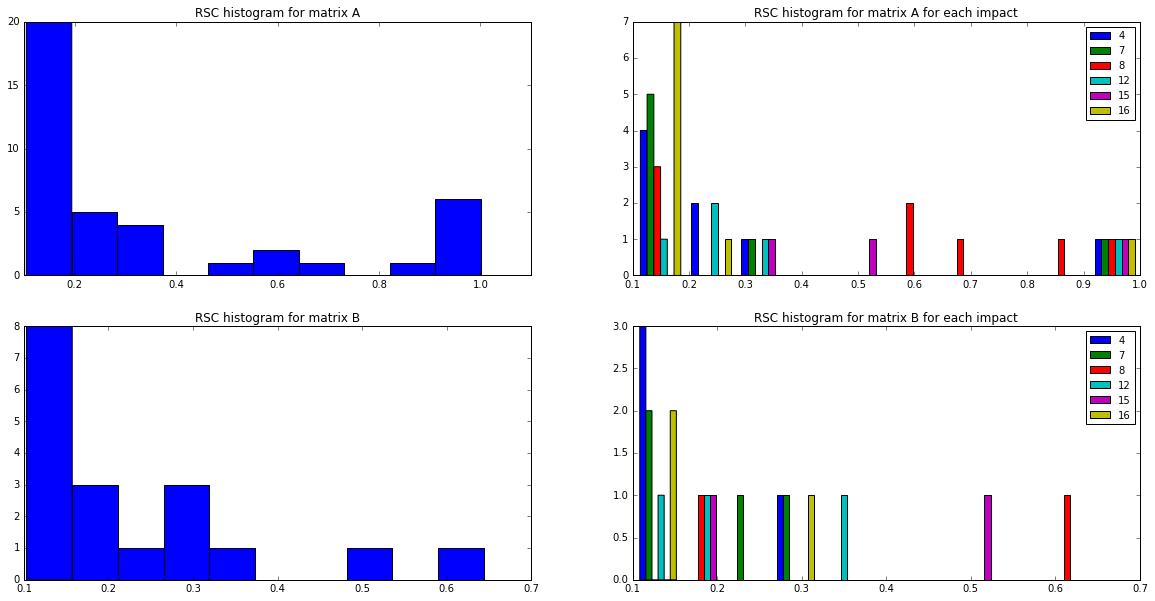

In [75]:
fig, axes = plt.subplots(2,2)
for line,(rsc,name) in enumerate([[rsca_sorted_df,'A'],[rscb_sorted_df,'B']]):
    axes[line][0].hist(abs(rsc['RSC']))
    axes[line][0].set_title('RSC histogram for matrix '+name)
    nonnull_k = [k for k in range(len(h)) if sum(abs(rsc[rsc.Impact==k]['RSC']))>0]
    data_hists = [abs(rsc[rsc.Impact==k]['RSC']) for k in nonnull_k]
    axes[line][1].hist(data_hists, histtype='bar',label=nonnull_k)
    axes[line][1].set_title('RSC histogram for matrix '+name+' for each impact')
    axes[line][1].legend(prop={'size': 10})
plt.show()

The same for the biospher matrix RSC: